NumExpr defaulting to 4 threads.


  0%|                                                                                         | 0/1387 [00:00<…


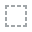
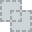
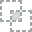
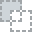
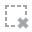
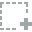
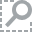
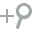
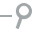
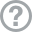
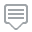
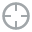
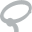
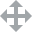
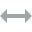
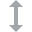
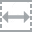
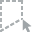
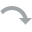
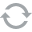
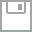
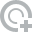
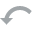
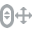
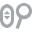
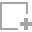
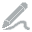
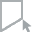
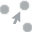
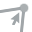
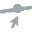

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataprep.eda import plot

trawlers_df = pd.read_csv('../data/trawlers.csv')
plot(trawlers_df)

In [2]:
trawlers_df['is_fishing'] = trawlers_df['is_fishing'].astype(int)
trawlers_df['is_fishing'] = [0 if x < 0 else 1 for x in trawlers_df['is_fishing']]
trawlers_df = trawlers_df[['is_fishing', 'lat', 'lon', 'course', 'speed', 'timestamp', 'distance_from_shore', 'distance_from_port', 'mmsi', 'source']]
trawlers_df = trawlers_df.dropna()

## Section 1 - Finding feature importance

Below is the code to determine feature importance using random forest and selecting the top 5 important features

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

from collections import Counter

train, test = train_test_split(trawlers_df, test_size=0.2, random_state=42)
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
feature_names = list(X_train)
feature_names


['lat',
 'lon',
 'course',
 'speed',
 'timestamp',
 'distance_from_shore',
 'distance_from_port',
 'mmsi',
 'source']

In [4]:
le = LabelEncoder()
X_train = X_train.apply(le.fit_transform)

scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1)
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
print(importances)

important_dict = {}
for name, importance in zip(feature_names, importances):
    important_dict[name] = importance
sort_important_dict = dict(Counter(important_dict).most_common(5))

X_train = X_train[sort_important_dict.keys()]
X_test = X_test[sort_important_dict.keys()]
print(X_train.columns)

[0.16179677 0.14505403 0.06943653 0.03296316 0.39042155 0.04533219
 0.06387707 0.05729996 0.03381873]
Index(['timestamp', 'lat', 'lon', 'course', 'distance_from_port'], dtype='object')


<BarContainer object of 5 artists>

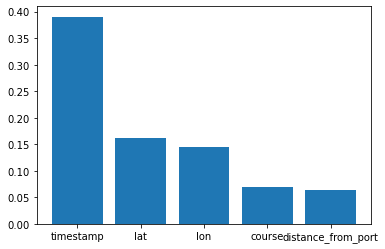

In [5]:
plt.bar(*zip(*sort_important_dict.items()))

## Section 2 - Evaluating feature importance

Below is the code to use the new set of features to train a gradient boosting tree, cross validation roc accuracy score is good.

However, upon futher evaluation using shap value, we noticed that there is a decrepancy between the train/test result

Futher evaluated the test data using a blackbox logistic regression model and using a f1 score as metrics to determine the accuracy

In [6]:
rfc2 = GradientBoostingClassifier(n_estimators=20)
rfc2.fit(X_train, y_train)
scores = cross_val_score(estimator=rfc2,X=X_train, y=y_train, cv=3, scoring="roc_auc", verbose=True)

print("AUC %.2f" % (scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AUC 0.94


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.6min finished


In [7]:
le = LabelEncoder()
X_test = X_test.apply(le.fit_transform)

scaler = MinMaxScaler()
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns)

### Shap values

In [8]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rfc2)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

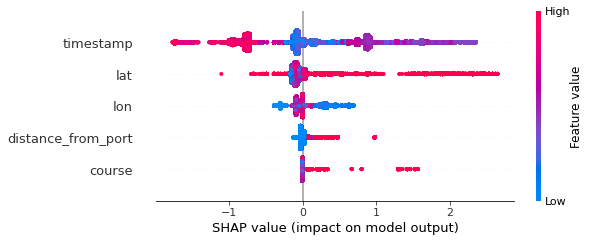

In [9]:
shap.summary_plot(shap_values, X_test)

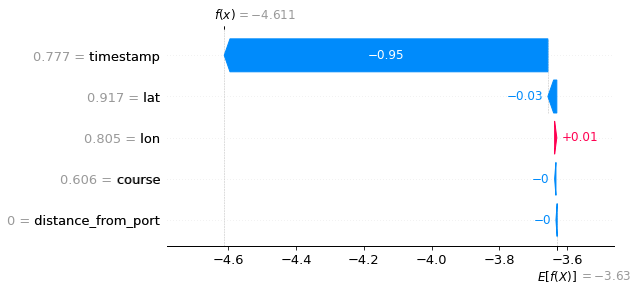

In [10]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0,:], X_test.iloc[0,:])

### Global surrogate - logistic regression

In [11]:
def explain_logistic_regression(lr, feature_names):
    # --- Write your code below ---
    plt.bar(feature_names, lr.coef_[0])
    plt.xticks(rotation='vertical')
    plt.ylabel('coefficient value')


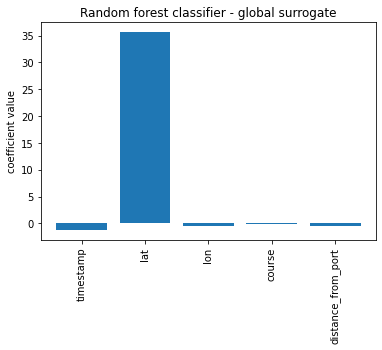

In [12]:
def global_surrogate(model, X, model_name):
    prediction = model.predict(X)
    lr_temp = LogisticRegression(solver='liblinear').fit(X, prediction)
    explain_logistic_regression(lr_temp, X_test.columns)
    plt.title(model_name)
    plt.show()
    plt.close()

global_surrogate(rfc2, X_test, 'Random forest classifier - global surrogate')

### f1 score and roc score

In [13]:
pred_prob = rfc2.predict(X_test)
f1_score(y_test, pred_prob)

0.323508954964354

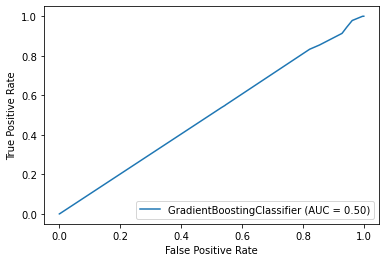

In [29]:
plot_roc_curve(estimator=rfc2,X=X_test, y=y_test)

## Section 3

Using intuition to determine important features and adjust table accordingly
Select

*note:

1. mmsi: mmsi should not affect model since it is a unique identifier for each vessel
2. lon/lat: longitude and latitude will be good display parameters but useless in model training (eg. training data might contain only africa fishing ground, but future prediction data might be from canada)
3. time: time is measured in unix time, which would be a terrible feature to train model since day in canada is night in china


In [15]:
trawlers_df = trawlers_df[['is_fishing', 'course', 'speed', 'distance_from_shore', 'distance_from_port']]
train, test = train_test_split(trawlers_df, test_size=0.2, random_state=42)
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
feature_names = list(X_train)
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_train

course     speed  distance_from_shore  distance_from_port
0        0.694912  0.000000             0.000000            0.002141
1        0.131311  0.026393             0.106335            0.121372
2        0.074560  0.003910             0.000350            0.000698
3        0.529550  0.000000             0.000000            0.000189
4        0.522113  0.000000             0.000000            0.000085
...           ...       ...                  ...                 ...
3495213  0.070450  0.041056             0.001979            0.002324
3495214  0.276908  0.000000             0.000000            0.000085
3495215  0.092759  0.030303             0.011117            0.010599
3495216  0.688845  0.095797             0.010359            0.002704
3495217  0.110176  0.031281             0.057558            0.099461

[3495218 rows x 4 columns]

In [16]:
rfc2.fit(X_train, y_train)
importances = rfc2.feature_importances_

In [17]:
scores = cross_val_score(estimator=rfc2,X=X_train, y=y_train, cv=3, scoring="roc_auc", verbose=True)

print("AUC %.2f" % (scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AUC 0.70


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min finished


Text(0, 0.5, 'feature importance')

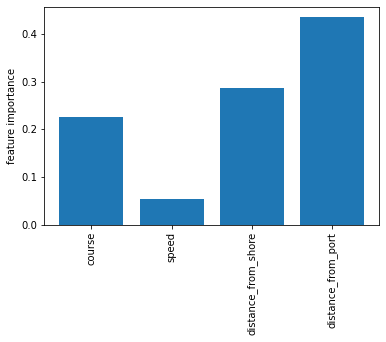

In [18]:
plt.bar(X_train.columns, importances)
plt.xticks(rotation='vertical')
plt.ylabel('feature importance')

### shap and roc score using new features

In [19]:
explainer = shap.TreeExplainer(rfc2)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

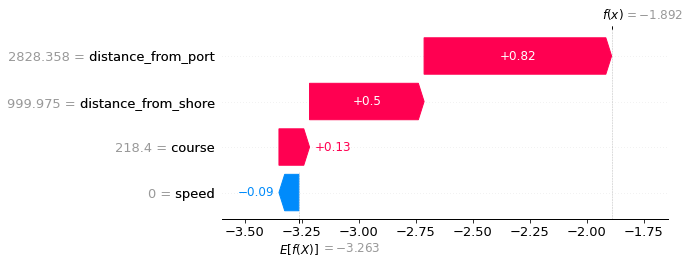

In [20]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0,:], X_test.iloc[0,:])